In [43]:
import csv
import random
import re
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from skimage.measure import EllipseModel

In [2]:
def floodfill(image: np.ndarray, y: int, x: int, processed: set) -> list:
    pixels_to_process = [(y, x)]
    particle = set()
    while pixels_to_process:
        y, x = pixels_to_process.pop(0)
        if (y, x) not in particle and image[y, x]:
            particle.add((y, x))
            if y - 1 >= 0:
                pixels_to_process.append((y - 1, x))
            if y + 1 < image.shape[0]:
                pixels_to_process.append((y + 1, x))
            if x - 1 >= 0:
                pixels_to_process.append((y, x - 1))
            if x + 1 < image.shape[1]:
                pixels_to_process.append((y, x + 1))
    processed.update(particle)
    return list(particle)


def extract_particles(image: np.ndarray) -> list:
    particles = []
    processed = set()
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if (y, x) not in processed and image[y, x]:
                particles.append(floodfill(image, y, x, processed))
    return particles


def extract_contours(particles: list) -> list:
    contours_ = []
    for particle in particles:
        im = np.zeros((1024, 1024), dtype=np.uint8)
        for y, x in particle:
            im[y, x] = 255
        contours, _ = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_.append(contours[0].squeeze())

    return contours_


def compute_particle_areas(particles: list) -> list:
    areas = []
    for particle in particles:
        areas.append(len(particle))
    return areas


def euclidean_distance(p1: np.ndarray, p2: np.ndarray) -> float:
    return np.sqrt(np.sum(np.power(p2 - p1, 2)))


def compute_contour_lengths(contours: list) -> list:
    lengths = []
    for contour in contours:
        length = 0
        for index in range(contour.shape[0] - 1):
            length += euclidean_distance(contour[index], contour[index + 1])
        length += euclidean_distance(contour[-1], contour[0])
        lengths.append(length)
    return lengths


def compute_porosities(particle_areas: list, contours: list) -> list:
    porosities = []
    for area, contour in zip(particle_areas, contours):
        hull = ConvexHull(contour)
        porosities.append(area / hull.volume)
    return porosities


def compute_ellipse_params(particles: list) -> list:
    params = []
    for particle in particles:
        ellipse = EllipseModel()
        ellipse.estimate(np.array(particle))
        params.append(ellipse.params)
    return params

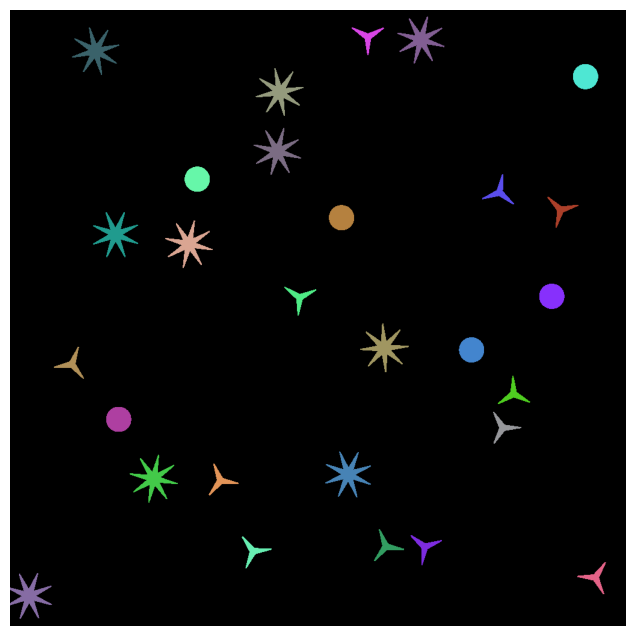

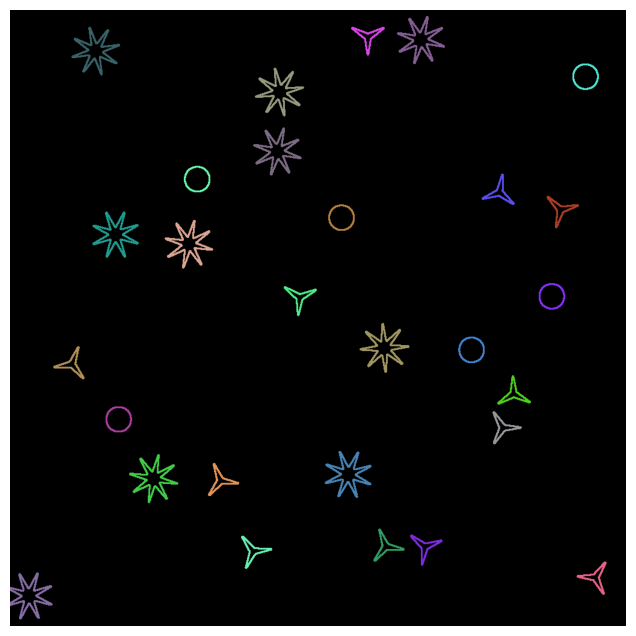

In [3]:
image = cv2.imread("shapes_binary.png", cv2.IMREAD_GRAYSCALE)
particles = extract_particles(image)
contours = extract_contours(particles)

colors = []
im = np.zeros((1024, 1024, 3), np.uint8)
for particle in particles:
    b, g, r = random.randint(30, 255), random.randint(30, 255), random.randint(30, 255)
    colors.append((b, g, r))
    for y, x in particle:
        im[y, x] = (b, g, r)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(im, cmap="gray")
plt.show()

im = np.zeros((1024, 1024, 3), np.uint8)
for i, c in enumerate(contours):
    b, g, r = random.randint(30, 255), random.randint(30, 255), random.randint(30, 255)
    im = cv2.drawContours(im, [c], 0, colors[i], 2)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(im, cmap="gray")
plt.show()

In [4]:
particle_areas = compute_particle_areas(particles)
contour_lengths = compute_contour_lengths(contours)
porosities = compute_porosities(particle_areas, contours)
ellipse_params = compute_ellipse_params(particles)

X_shapes_binary = []
for i in range(len(particle_areas)):
    X_shapes_binary.append((particle_areas[i], contour_lengths[i], porosities[i], *ellipse_params[i]))

In [59]:
training_dir = Path("./training_data")
X = []
y = []
for image_path in sorted(training_dir.glob("*.png")):
    m = re.match(r".*image_([0-9]+).png", str(image_path))
    csv_path = training_dir / f"shapes_{m.group(1)}.csv"

    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    particles = extract_particles(image)
    contours = extract_contours(particles)
    particle_areas = compute_particle_areas(particles)
    contour_lengths = compute_contour_lengths(contours)
    porosities = compute_porosities(particle_areas, contours)
    ellipse_params = compute_ellipse_params(particles)

    with open(csv_path, "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=";")
        for row in reader:
            pixel, label = (int(row[1]), int(row[0])), row[2]
            for i, particle in enumerate(particles):
                if pixel in particle:
                    X.append((particle_areas[i], contour_lengths[i], porosities[i], *ellipse_params[i]))
                    y.append(label)


/home/m/Documents/advanced_computer_vision_ss2024_Pijarowski_Matthias/venv/lib/python3.10/site-packages/skimage/measure/fit.py:522: RuntimeWarning: invalid value encountered in scalar divide
  phi = 0.5 * np.arctan((2.0 * b) / (a - c))


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [65]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
tree.score(X_test, y_test)

1.0